# e-Science Tjärnö 

In [29]:
# Autoload external files/functions

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Import necessary libraries and functions

import xarray as xr
from sizedist_utils import compute_Nx_ebas_cleaned  # Made by Sara: size distribution to number concentration integration
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022')

['escience2022/Ada',
 'escience2022/Antoine',
 'escience2022/Dominic',
 'escience2022/ESA_SMOS_sss',
 'escience2022/Remy',
 'escience2022/Sara',
 'escience2022/Zhihong']

## Load and prepare data

## Load and prepare data

### Zeppelin station

In [31]:
# Zeppelin data
data1 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part1.nc4')
data2 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part2.nc4')


# Cloud flag
data1_cl_mask=data1.where(data1['cloud_flag']=='yes')
data1_no_cl = data1.where(data1['cloud_flag']=='no')

# Filter out cold temperatures (< -4C) to remove ice from observations

data1_cl_mask_warm=data1_cl_mask.where(data1_cl_mask['temperature'] > -4.0)


### NorESM data

In [73]:
# Pick variables -- Cloud Properties
varl = ['AWNC', 'AREL', 'FREQL', 'N100','N50', 'N30'] 

path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

def make_file_path_for_var(v,):
    return path_to_data+v+postfix

filelist = [make_file_path_for_var(v) for v in varl]

list_of_s3_obj = [s3.open(s) for s in filelist]


ds = xr.open_mfdataset(list_of_s3_obj)

In [74]:
# Define and add AWNC_incld to dataset

ds['AWNC_incld'] = ds['AWNC']/ds['FREQL']

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


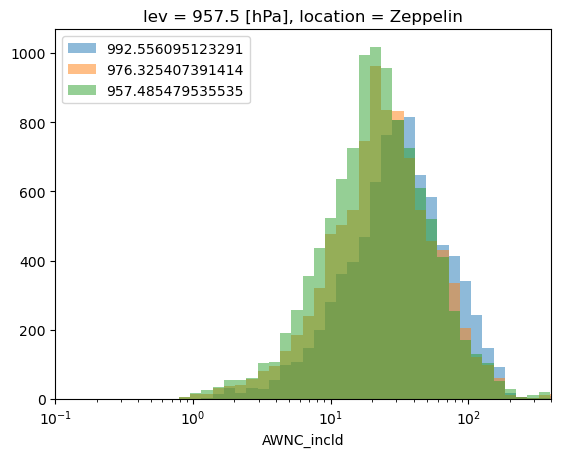

In [34]:
levels= [-1, -2, -3]
for i in levels:
 ds.isel(lev=i).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, label=ds.lev[i])#, density=True)

plt.xscale('log')
plt.xlim([0.1,400])
plt.legend()

## Integrating size distribution to droplet number concentrations

Naming: 
* Nx_cloud : integrated with compute_Nx_ebas_cleaned (d>1e-9), from cloud masked cloud particle size distribution - Fog monitor
* Nx_cloudresidual : variable 'total_aerosol_particle_concentration' in cloud masked data1 - CVI
* Nx_NorESM : AWNC_incld at level -1, location Zeppelin.


In [35]:
# Calculate/extract cloud droplet number concentrations

Nx_cloud =compute_Nx_ebas_cleaned(data1_cl_mask,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloud_warm =compute_Nx_ebas_cleaned(data1_cl_mask_warm,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloudresidual = data1_cl_mask.total_aerosol_particle_concentration
Nx_cloudresidual_warm= data1_cl_mask_warm.total_aerosol_particle_concentration
Nx_NorESM = ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld']



/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


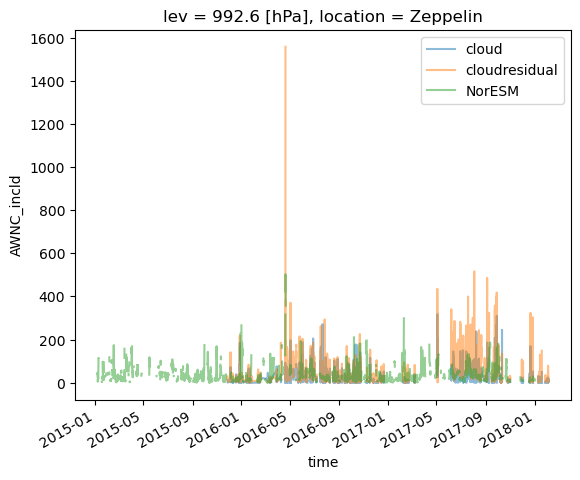

In [36]:
# Plot check
Nx_cloud.plot(alpha=0.5,label ='cloud')
Nx_cloudresidual.plot(alpha=0.5,label ='cloudresidual')
Nx_NorESM.plot(alpha=0.5, label='NorESM')
plt.legend()

### Resample observations to hourly data

In [37]:
Nx_cloud_hourly=Nx_cloud.resample(time='H').mean()
Nx_cloud_warm_hourly=Nx_cloud.resample(time='H').mean()
Nx_cloudresidual_hourly=Nx_cloudresidual.resample(time='H').mean()
Nx_cloudresidual_warm_hourly=Nx_cloudresidual_warm.resample(time='H').mean()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


Text(0, 0.5, '#/cm⁻³')

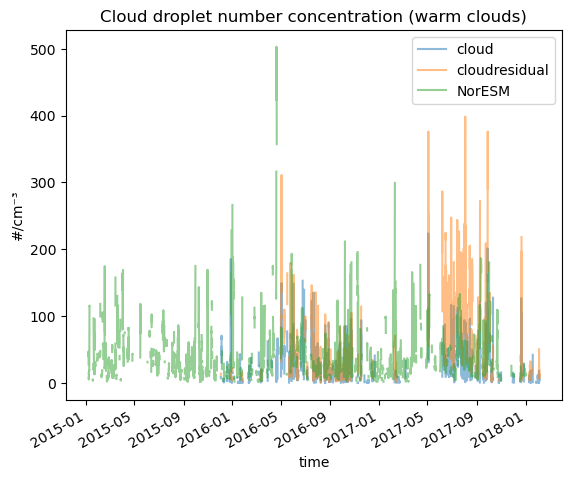

In [46]:
# Using > -4C

Nx_cloud_warm_hourly.plot(alpha=0.5,label ='cloud')
Nx_cloudresidual_warm_hourly.plot(alpha=0.5,label ='cloudresidual')
Nx_NorESM.plot(alpha=0.5, label='NorESM')
plt.legend()
plt.title('Cloud droplet number concentration (warm clouds)')
plt.ylabel('#/cm⁻³')

# Histograms

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


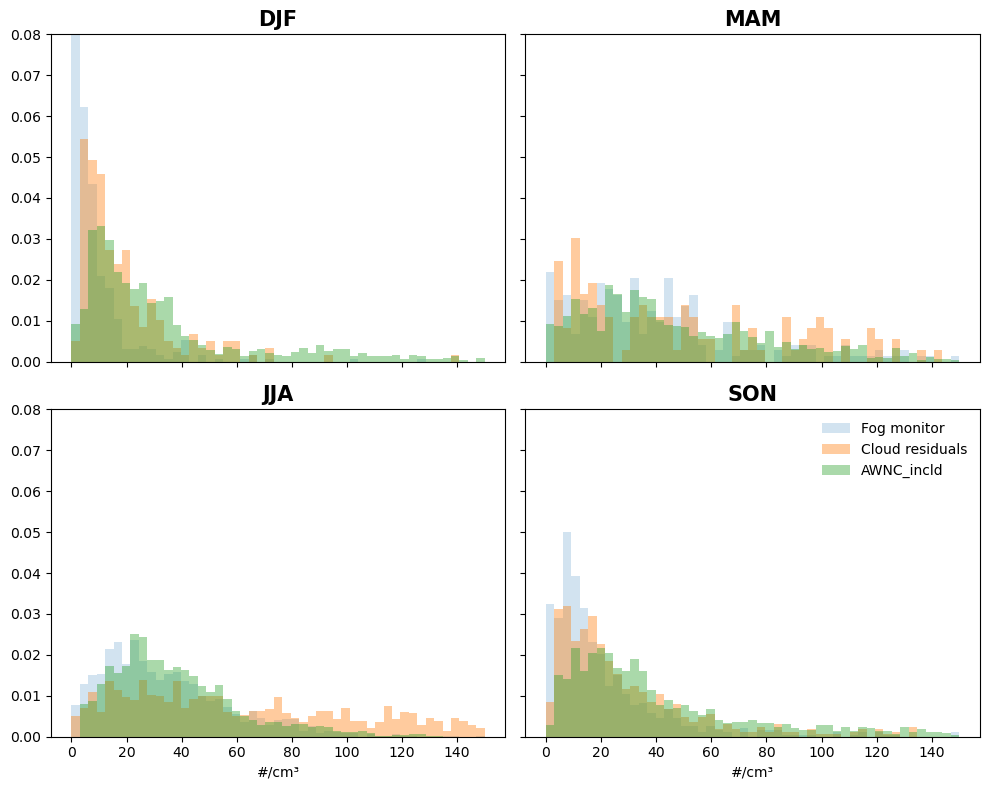

In [50]:
# Group by seasons

ds_seasons = ds.groupby('time.season')
Nx_cloud_seasons = Nx_cloud_hourly.groupby('time.season')
Nx_cloudresidual_seasons = Nx_cloudresidual_hourly.groupby('time.season')
Nx_cloud_warm_seasons = Nx_cloud_warm_hourly.groupby('time.season')
Nx_cloudresidual_warm_seasons = Nx_cloudresidual_warm_hourly.groupby('time.season')


season_str=['DJF', 'MAM', 'JJA', 'SON']



# Plot histograms with subplots of each season.

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 8))


for n_ax, ax in zip(range(0, 4), axs.flatten()):

    Nx_cloud_warm_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.2, bins=np.linspace(0,150,50), label='Fog monitor', ax = ax )
    Nx_cloudresidual_warm_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), label='Cloud residuals', ax = ax)
    ds_seasons[season_str[n_ax]].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), ax= ax,
                                                                                               label='AWNC_incld')
    if n_ax==3:
        ax.legend(frameon=False)
    if n_ax>=2:
        ax.set_xlabel('#/cm³')
    else:
        ax.set_xlabel('')
    plt.ylim([0,0.08])
    ax.set_title(season_str[n_ax], fontweight='bold', fontsize=15)
plt.tight_layout()


# Scatter plots

### Prepare data

In [95]:
# Calculate N100,N50 and N25 from all_air inlet aerosol particle size distribution

N100_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=100e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N50_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=50e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N25_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=25e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')


# Make daily means 

N100_allair_daily = N100_allair.resample(time='D').mean()
N50_allair_daily = N50_allair.resample(time='D').mean()
N25_allair_daily = N25_allair.resample(time='D').mean()
Nx_cloud_daily = Nx_cloud.resample(time='D').mean()
Nx_cloudresidual_daily = Nx_cloudresidual.resample(time='D').mean()
ds_daily = ds.resample(time='D').mean()

# Merging obs. variables to get droplet number and particle number in one

N100_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N100_allair_daily.rename('N100_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N50_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N50_allair_daily.rename('N50_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N25_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N25_allair_daily.rename('N25_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])

#Extracting time series common for obs and model: 2015-11-27 - 2018-01-02

N100_daily.sel(time=slice('2015-11-27','2018-01-02'))
N50_daily.sel(time=slice('2015-11-27','2018-01-02'))
N25_daily.sel(time=slice('2015-11-27','2018-01-02'))
ds_daily.sel(time=slice('2015-11-27','2018-01-02'))

# Remove NAN (for regression function)
N100_daily_nonan=N100_daily.dropna('time')
N50_daily_nonan= N50_daily.dropna('time')
N25_daily_nonan= N25_daily.dropna('time')
ds_nonan = ds_daily.isel(lev=-1).sel(location='Zeppelin').dropna('time')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis,

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/cond

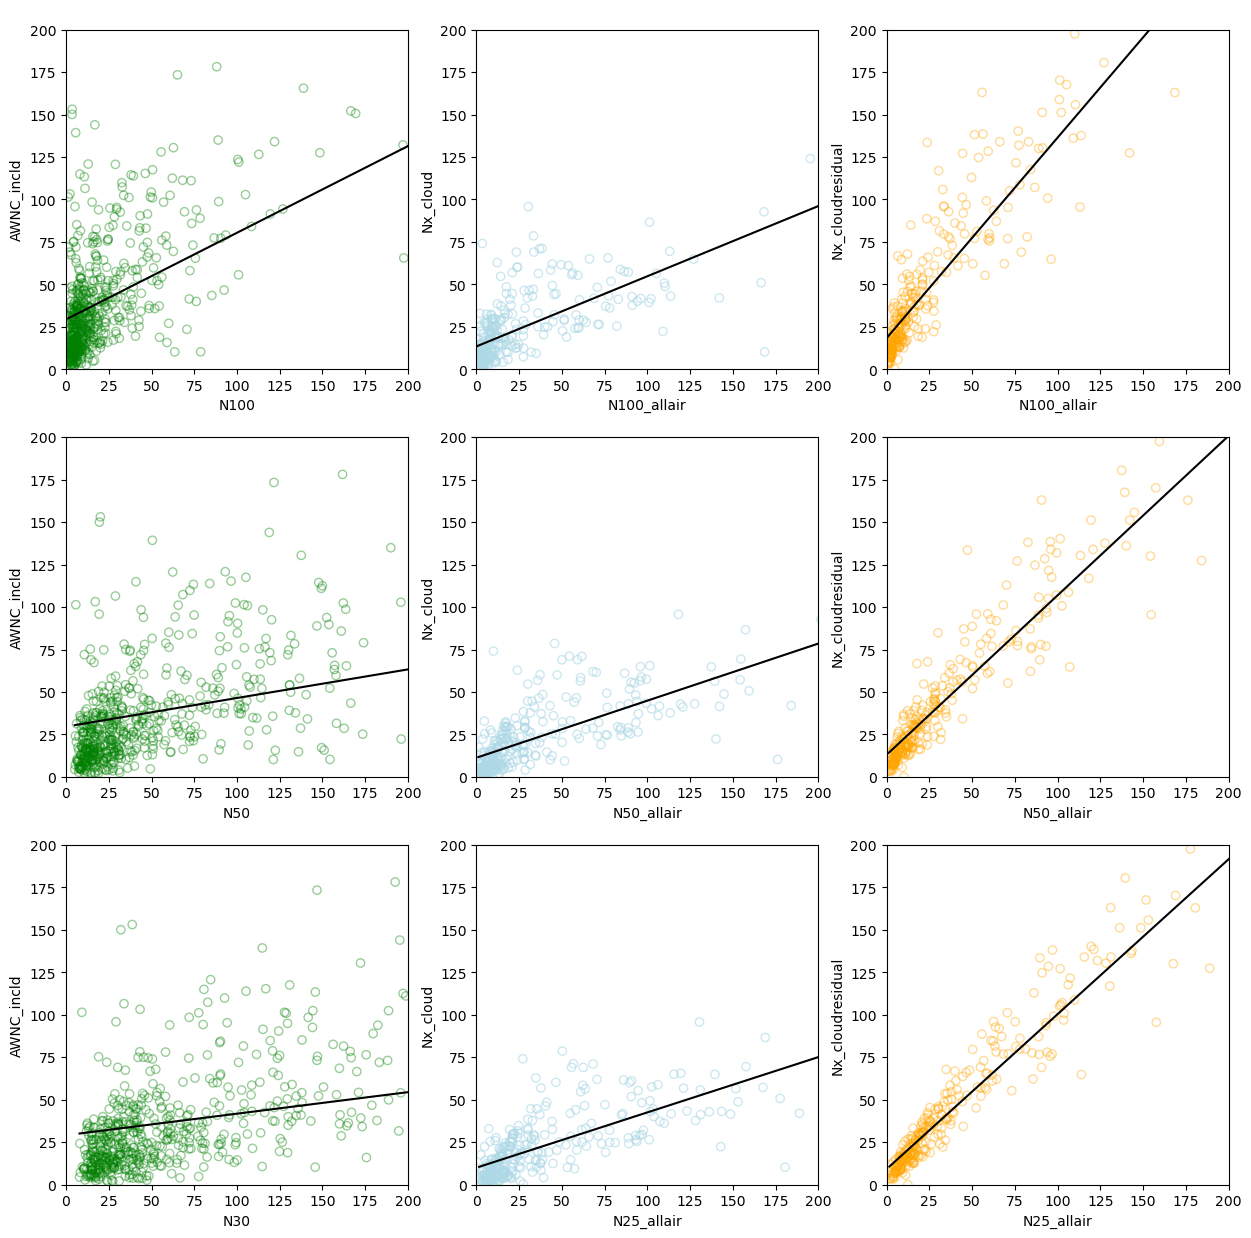

In [96]:

fig, axs = plt.subplots(3,3, figsize=(15,15))

#-------------------------------------------------------------------
ds_nonan.plot.scatter('N100', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[0,0])

z0 = np.polyfit(ds_nonan['N100'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N100'].min(), ds_nonan['N100'].max())
axs[0,0].plot(x0, p0(x0), c='k')

#-------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[0,1])

z1 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[0,1].plot(x1, p1(x1), c='k')


#-----------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[0,2])

z2 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[0,2].plot(x2, p2(x2), c='k')





    
#------------------------------------------------------------    
#------------------------------------------------------------
ds_daily.isel(lev=-1).sel(location='Zeppelin').plot.scatter('N50', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[1,0])


z0 = np.polyfit(ds_nonan['N50'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N50'].min(), ds_nonan['N50'].max())
axs[1,0].plot(x0, p0(x0), c='k')


#-------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[1,1])

z1 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[1,1].plot(x1, p1(x1), c='k')



#--------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[1,2])

z2 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[1,2].plot(x2, p2(x2), c='k')

    

    

#-------------------------------------------------------------------    
#-------------------------------------------------------------------
ds_nonan.plot.scatter('N30', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[2,0])

z0 = np.polyfit(ds_nonan['N30'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N30'].min(), ds_nonan['N30'].max())
axs[2,0].plot(x0, p0(x0), c='k')

#-------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[2,1])

z1 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[2,1].plot(x1, p1(x1), c='k')


#-----------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[2,2])

z2 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[2,2].plot(x2, p2(x2), c='k')

    
    
    
for axi in axs.ravel():
    axi.set_xlim([0,200])
    axi.set_ylim([0,200])
    axi.set_title(' ')



/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis,

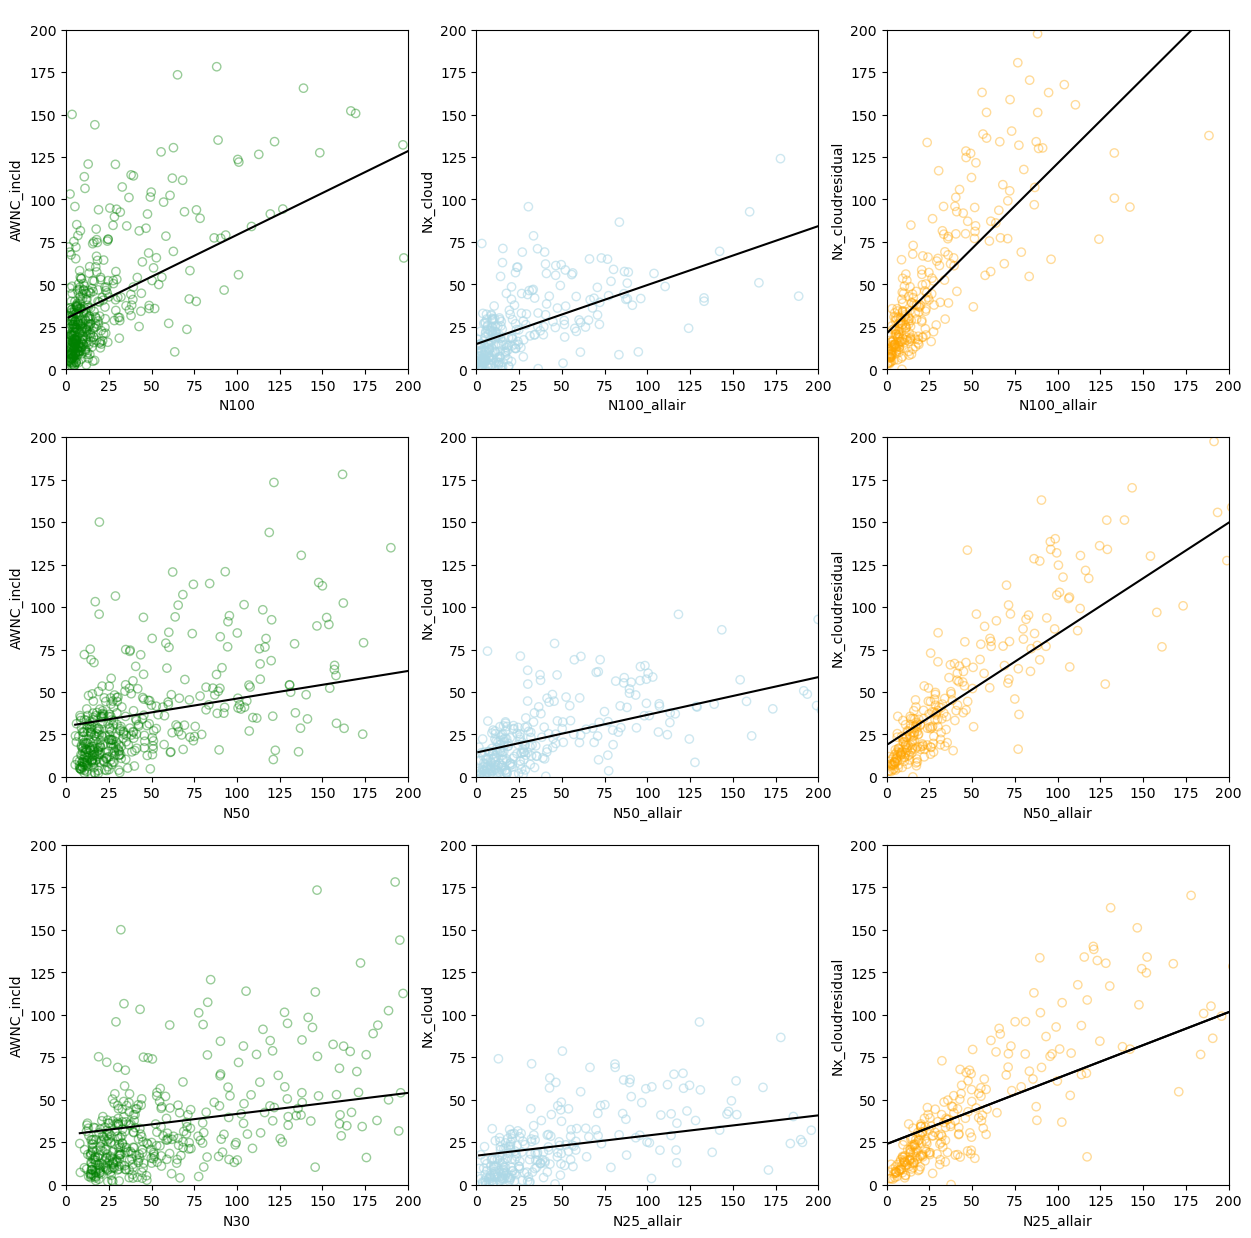

In [106]:
# TEST WITHOUT CLOUD MASK

# Calculate N100,N50 and N25 from all_air inlet aerosol particle size distribution

N100_allair=compute_Nx_ebas_cleaned(data1,x=100e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N50_allair=compute_Nx_ebas_cleaned(data1,x=50e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N25_allair=compute_Nx_ebas_cleaned(data1,x=25e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')


# Make daily means 

N100_allair_daily = N100_allair.resample(time='D').mean()
N50_allair_daily = N50_allair.resample(time='D').mean()
N25_allair_daily = N25_allair.resample(time='D').mean()
Nx_cloud_daily = Nx_cloud.resample(time='D').mean()
Nx_cloudresidual_daily = Nx_cloudresidual.resample(time='D').mean()
ds_daily = ds.resample(time='D').mean()

# Merging obs. variables to get droplet number and particle number in one

N100_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N100_allair_daily.rename('N100_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N50_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N50_allair_daily.rename('N50_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N25_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N25_allair_daily.rename('N25_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])

#Extracting time series common for obs and model: 2015-11-27 - 2018-01-02

N100_daily = N100_daily.sel(time=slice('2015-11-27','2018-01-02'))
N50_daily = N50_daily.sel(time=slice('2015-11-27','2018-01-02'))
N25_daily = N25_daily.sel(time=slice('2015-11-27','2018-01-02'))
ds_daily = ds_daily.sel(time=slice('2015-11-27','2018-01-02'))

# Remove NAN (for regression function)
N100_daily_nonan=N100_daily.dropna('time')
N50_daily_nonan= N50_daily.dropna('time')
N25_daily_nonan= N25_daily.dropna('time')
ds_nonan = ds_daily.isel(lev=-1).sel(location='Zeppelin').dropna('time')




fig, axs = plt.subplots(3,3, figsize=(15,15))

#-------------------------------------------------------------------
ds_nonan.plot.scatter('N100', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[0,0])

z0 = np.polyfit(ds_nonan['N100'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N100'].min(), ds_nonan['N100'].max())
axs[0,0].plot(x0, p0(x0), c='k')

#-------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[0,1])

z1 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[0,1].plot(x1, p1(x1), c='k')


#-----------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[0,2])

z2 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[0,2].plot(x2, p2(x2), c='k')





    
#------------------------------------------------------------    
#------------------------------------------------------------
ds_nonan.plot.scatter('N50', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[1,0])


z0 = np.polyfit(ds_nonan['N50'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N50'].min(), ds_nonan['N50'].max())
axs[1,0].plot(x0, p0(x0), c='k')


#-------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[1,1])

z1 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[1,1].plot(x1, p1(x1), c='k')



#--------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[1,2])

z2 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[1,2].plot(x2, p2(x2), c='k')

    

    

#-------------------------------------------------------------------    
#-------------------------------------------------------------------
ds_nonan.plot.scatter('N30', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[2,0])

z0 = np.polyfit(ds_nonan['N30'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N30'].min(), ds_nonan['N30'].max())
axs[2,0].plot(x0, p0(x0), c='k')

#-------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[2,1])

z1 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[2,1].plot(x1, p1(x1), c='k')


#-----------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[2,2])

z2 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x3 = np.linspace(0,200)
x2=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[2,2].plot(x2, p2(x2), c='k')
axs[2,2].plot(x3, p2(x3), c='k')
    
    
    
for axi in axs.ravel():
    axi.set_xlim([0,200])
    axi.set_ylim([0,200])
    axi.set_title(' ')



In [102]:
ds_nonan

<xarray.Dataset>
Dimensions:     (time: 612)
Coordinates:
    lev         float64 992.6
    location    <U8 'Zeppelin'
  * time        (time) datetime64[ns] 2015-01-06 2015-01-07 ... 2018-01-02
Data variables:
    AREL        (time) float32 dask.array<chunksize=(612,), meta=np.ndarray>
    AWNC        (time) float32 dask.array<chunksize=(612,), meta=np.ndarray>
    FREQL       (time) float32 dask.array<chunksize=(612,), meta=np.ndarray>
    N100        (time) float64 dask.array<chunksize=(612,), meta=np.ndarray>
    N30         (time) float64 dask.array<chunksize=(612,), meta=np.ndarray>
    N50         (time) float64 dask.array<chunksize=(612,), meta=np.ndarray>
    AWNC_incld  (time) float32 dask.array<chunksize=(612,), meta=np.ndarray>

In [103]:
N100_daily_nonan

<xarray.Dataset>
Dimensions:            (time: 283)
Coordinates:
  * time               (time) datetime64[ns] 2015-11-27 ... 2018-02-04
    limit              <U3 'top'
    cloud_diameters    float64 4.599e-05
    aerosol_diameters  float64 1.05e-07
Data variables:
    Nx_cloud           (time) float64 4.906 5.056 7.943 ... 1.164 5.335 5.201
    N100_allair        (time) float64 5.413 3.133 7.545 ... 46.8 15.31 8.686
    Nx_cloudresidual   (time) float64 12.51 9.439 12.97 ... 16.05 21.35 10.37